In [16]:
import os
import cv2
import numpy as np

def load_images(base_path, folders, image_size):
    data = []
    labels = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    
    for label, folder in enumerate(folders):
        folder_path = os.path.join(base_path, folder)
        print(f"Checking folder: {folder_path}")
        
        # For each subfolder inside the folder (e.g. 01_palm)
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            if not os.path.isdir(subfolder_path):
                continue
            
            images = os.listdir(subfolder_path)
            print(f"  Found {len(images)} files in {subfolder_path}")
            
            for img_name in images:
                if not img_name.lower().endswith(valid_extensions):
                    print(f"    Skipping non-image file: {img_name}")
                    continue
                
                img_path = os.path.join(subfolder_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"    Failed to load image: {img_path}")
                    continue
                
                img = cv2.resize(img, image_size)
                data.append(img)
                labels.append(label)
    
    if len(data) == 0:
        raise Exception("No images loaded, please check folder paths and image files.")
    
    data = np.array(data, dtype=np.float32)
    labels = np.array(labels)
    return data, labels

# Example usage:
BASE_PATH = "Train"
FOLDER_NAMES = [f"{i:02d}" for i in range(10)]  # ['00', '01', ..., '09']
IMAGE_SIZE = (64, 64)  # your desired image size

X, y = load_images(BASE_PATH, FOLDER_NAMES, IMAGE_SIZE)
print(f"Total images loaded: {len(X)}")


Checking folder: Train\00
  Found 200 files in Train\00\01_palm
  Found 200 files in Train\00\02_l
  Found 200 files in Train\00\03_fist
  Found 200 files in Train\00\04_fist_moved
  Found 200 files in Train\00\05_thumb
  Found 200 files in Train\00\06_index
  Found 200 files in Train\00\07_ok
  Found 200 files in Train\00\08_palm_moved
  Found 200 files in Train\00\09_c
  Found 200 files in Train\00\10_down
Checking folder: Train\01
  Found 200 files in Train\01\01_palm
  Found 200 files in Train\01\02_l
  Found 200 files in Train\01\03_fist
  Found 200 files in Train\01\04_fist_moved
  Found 200 files in Train\01\05_thumb
  Found 200 files in Train\01\06_index
  Found 200 files in Train\01\07_ok
  Found 200 files in Train\01\08_palm_moved
  Found 200 files in Train\01\09_c
  Found 200 files in Train\01\10_down
Checking folder: Train\02
  Found 200 files in Train\02\01_palm
  Found 200 files in Train\02\02_l
  Found 200 files in Train\02\03_fist
  Found 200 files in Train\02\04_fist_m

In [20]:
# Normalize pixel values
X = X / 255.0

# Shuffle data (optional)
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

# You can also reshape if needed, e.g. for CNN input:
X = X.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)  # add channel dimension


In [22]:
from sklearn.model_selection import train_test_split

# Split data (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")


Training samples: 16000
Validation samples: 4000


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = len(set(y))  # number of unique labels

model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),  # grayscale images
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,866 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val)
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.1819 - loss: 2.1527 - val_accuracy: 0.5798 - val_loss: 1.1753
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.6706 - loss: 0.9498 - val_accuracy: 0.8698 - val_loss: 0.4796
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.8720 - loss: 0.4099 - val_accuracy: 0.9427 - val_loss: 0.2269
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9447 - loss: 0.1967 - val_accuracy: 0.9582 - val_loss: 0.1298
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9671 - loss: 0.1096 - val_accuracy: 0.9765 - val_loss: 0.0779
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.9792 - loss: 0.0717 - val_accuracy: 0.9837 - val_loss: 0.0631
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.9810 - loss: 0.0574 - val_accuracy: 0.9725 - val_loss: 0.0788
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.9844 - loss: 0.0492 - 

In [30]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_acc*100:.2f}%")

# Save model
model.save('my_model.keras')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9889 - loss: 0.0319
Validation accuracy: 98.87%


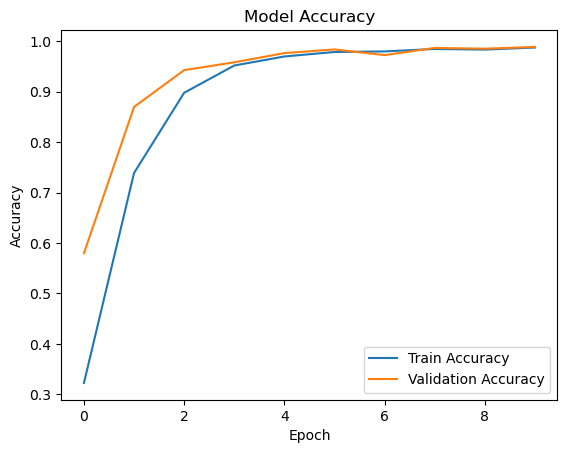

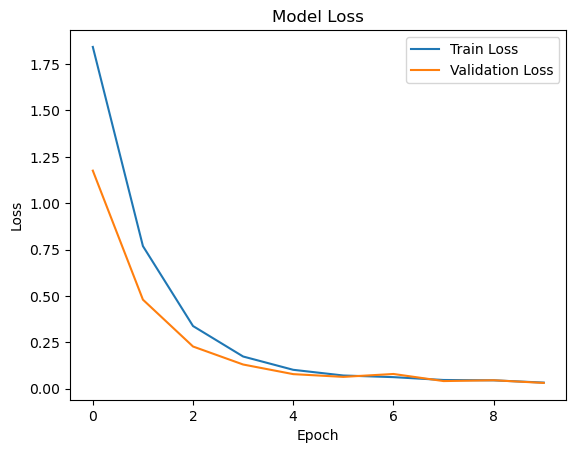

In [32]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('my_model.keras')

# Class labels (update these to match your training classes)
class_labels = [
    "palm", "l", "fist", "fist_moved", "thumb",
    "index", "ok", "palm_moved", "c", "down"
]

# Expected image size
IMAGE_SIZE = 64

# Open webcam (0 = default camera)
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess: crop center and resize to 64x64
    img = cv2.resize(frame, (IMAGE_SIZE, IMAGE_SIZE))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)      # Convert to grayscale
    img_gray = img_gray.reshape(IMAGE_SIZE, IMAGE_SIZE, 1)  # Reshape for model
    img_gray = img_gray / 255.0                            # Normalize
    img_gray = np.expand_dims(img_gray, axis=0)            # Add batch dimension

    # Predict
    predictions = model.predict(img_gray)
    predicted_class = class_labels[np.argmax(predictions)]
    confidence = np.max(predictions)

    # Display prediction
    label = f"{predicted_class} ({confidence*100:.2f}%)"
    cv2.putText(frame, label, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Hand Gesture Prediction", frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

# import cv2
import numpy as np
from tensorflow.keras.models import load_model
import time
import datetime

# Load your trained model
model = load_model('my_model.keras')

# Class labels (update if needed)
class_labels = ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb',
                '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']

# Image size your model expects (adjust if needed)
IMAGE_SIZE = 64

# Start webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Define region of interest (ROI)
    roi = frame[100:400, 100:400]  # You can adjust this

    # Resize and convert to grayscale if model expects (64, 64, 1)
    roi_resized = cv2.resize(roi, (IMAGE_SIZE, IMAGE_SIZE))
    img_gray = cv2.cvtColor(roi_resized, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray / 255.0
    img_gray = np.expand_dims(img_gray, axis=-1)  # Add channel
    img_gray = np.expand_dims(img_gray, axis=0)   # Add batch

    # Predict gesture
    start = time.time()
    predictions = model.predict(img_gray, verbose=0)
    end = time.time()

    predicted_class = class_labels[np.argmax(predictions)]
    confidence = np.max(predictions)
    fps = 1 / (end - start)

    # Print prediction
    print(f"Predicted: {predicted_class} ({confidence:.2f}) - FPS: {fps:.2f}")

    # Log to file
    with open("prediction_log.txt", "a") as f:
        f.write(f"{datetime.datetime.now()} - {predicted_class} - Confidence: {confidence:.2f}\n")

    # Gesture-based action
    if predicted_class == "01_palm":
        gesture_msg = "🖐️ Palm - Stop signal"
    elif predicted_class == "05_thumb":
        gesture_msg = "👍 Thumbs Up - All good!"
    elif predicted_class == "06_index":
        gesture_msg = "☝️ Index Finger - Pointing"
    else:
        gesture_msg = f"Detected: {predicted_class}"

    # Show prediction on screen
    cv2.putText(frame, gesture_msg, (10, 50), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0), 2, cv2.LINE_AA)

    # Draw ROI
    cv2.rectangle(frame, (100, 100), (400, 400), (255, 0, 0), 2)

    cv2.imshow("Gesture Detection", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clean up
cap.release()
cv2.destroyAllWindows()
